In [45]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
data = pd.read_csv('Data/2018.csv')

In [14]:
data.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

In [99]:
# Select only first 3 months
df = data[data.FL_DATE < '2018-04-01']
# Select variables we want to use
df = pd.concat([df['TAXI_OUT'],df['ORIGIN'],df['OP_CARRIER']],axis=1)
# Drop NA
df = df[df['TAXI_OUT'].notna()]
df = df[df['ORIGIN'].notna()]
df = df[df['OP_CARRIER'].notna()]
# 1-hot encode ORIGIN
onehot_origin = pd.get_dummies(df.ORIGIN)
onehot_carrier = pd.get_dummies(df.OP_CARRIER)
df = df.drop('ORIGIN',axis=1)
df = df.drop('OP_CARRIER',axis=1)
df = pd.concat([df,onehot_origin,onehot_carrier],axis=1)
print(df.shape)

(1659665, 356)


In [89]:
df

,TAXI_OUT,ABE,ABI,ABQ,ABR,ABY,ACT,ACV,ACY,ADK,...,TYS,UIN,USA,VLD,VPS,WRG,XNA,YAK,YNG,YUM
0,15.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702831,12.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702832,13.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702833,9.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702834,25.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


{'whiskers': [<matplotlib.lines.Line2D at 0x1ff1abcca30>,
 'caps': [<matplotlib.lines.Line2D at 0x1ff1abdb130>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ff1abcc760>],
 'medians': [<matplotlib.lines.Line2D at 0x1ff1abdb7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ff1abdbb20>],
 'means': []}

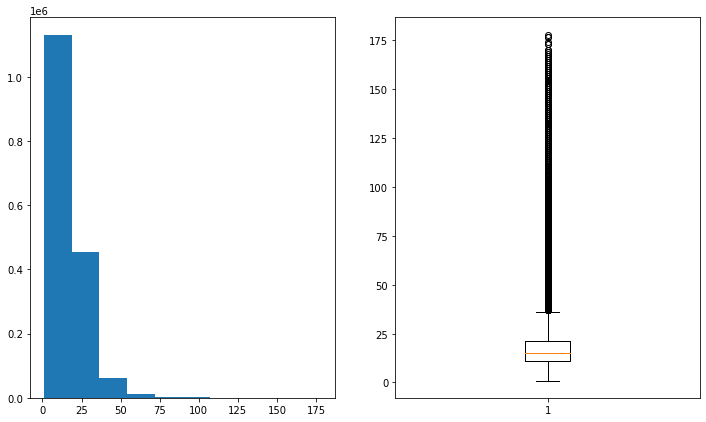

In [76]:
# Investigate TAXI_OUT
fig,ax = plt.subplots(1,2,figsize=(12,7))
ax[0].hist(df.TAXI_OUT)
ax[1].boxplot(df.TAXI_OUT)

<AxesSubplot:>

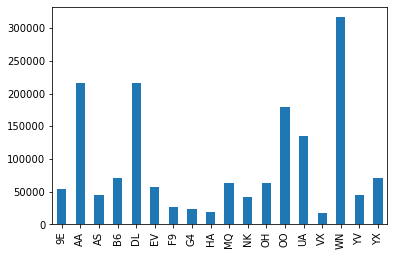

In [140]:
origin_sum = df[onehot_carrier.columns].sum()
origin_sum.plot.bar()

In [150]:
origin_sum = onehot_origin.sum()
sorted(origin_sum,reverse=True)

[91196,
 73653,
 64684,
 53411,
 53119,
 51852,
 43404,
 40836,
 40800,
 38434,
 38098,
 36720,
 35777,
 34684,
 32642,
 31448,
 31260,
 30557,
 28492,
 27474,
 25261,
 25234,
 24222,
 22549,
 20724,
 19518,
 18667,
 17238,
 16489,
 15162,
 14597,
 14383,
 13935,
 13718,
 13501,
 12829,
 12744,
 12155,
 11830,
 11617,
 11574,
 11292,
 11248,
 11035,
 10884,
 10537,
 10355,
 9699,
 9060,
 8317,
 7445,
 6543,
 6431,
 6346,
 6130,
 5800,
 5655,
 5483,
 5307,
 5223,
 5220,
 5052,
 5047,
 4752,
 4667,
 4624,
 4547,
 4409,
 4391,
 4185,
 4096,
 4040,
 3998,
 3948,
 3702,
 3642,
 3582,
 3565,
 3443,
 3347,
 3269,
 3127,
 3108,
 3086,
 3003,
 2980,
 2971,
 2967,
 2759,
 2757,
 2730,
 2585,
 2569,
 2487,
 2448,
 2394,
 2309,
 2298,
 2266,
 2151,
 2142,
 2092,
 2088,
 2068,
 1956,
 1915,
 1902,
 1900,
 1849,
 1800,
 1772,
 1757,
 1739,
 1727,
 1629,
 1607,
 1569,
 1541,
 1524,
 1521,
 1508,
 1500,
 1500,
 1484,
 1446,
 1443,
 1437,
 1431,
 1426,
 1417,
 1405,
 1387,
 1358,
 1309,
 1269,
 1248,
 

In [151]:
# Compare shape to see effect of preprocessing
print('Shape before:',data.shape,'\n Shape after:',df.shape)

Shape before: (7213446, 28) 
 Shape after: (1659665, 356)


In [152]:
# Save as new dataframe
df.to_csv('Data/df_cush.csv',index=False)